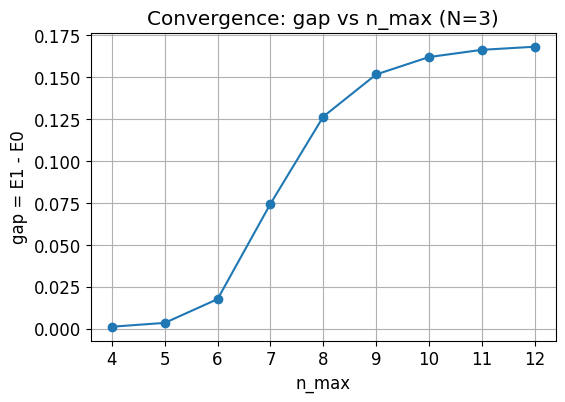

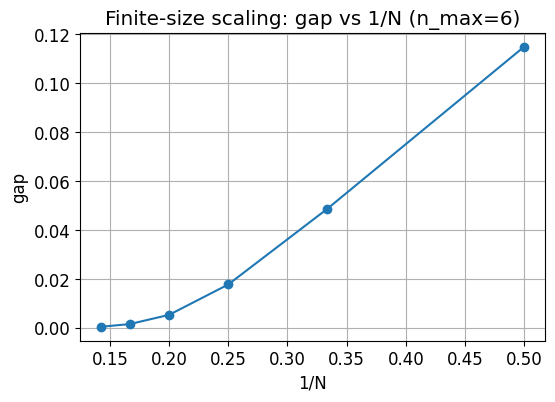

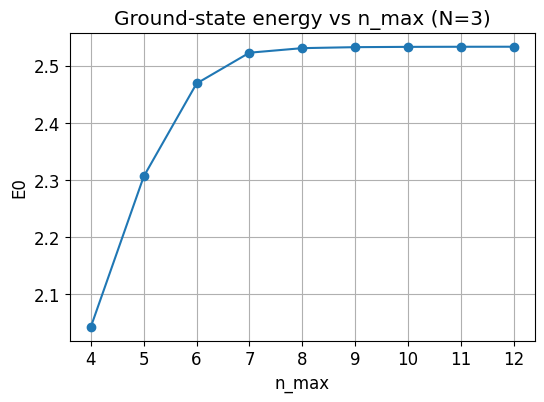

In [20]:
# ============================
# Task 1 — Clean ED Convergence Plots
# 3 Plots, 12–16 data points each
# ============================

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import expm
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(6,4),'font.size':12})

# -----------------------------
# HO basis local operators
# -----------------------------
def local_ho_operators(n_max, omega=1.0):
    n = n_max
    rows, cols, data = [], [], []
    for i in range(n-1):
        rows.append(i); cols.append(i+1); data.append(np.sqrt(i+1))
    a = sp.csr_matrix((data,(rows,cols)),shape=(n,n),dtype=np.complex128)
    adag = a.getH()
    phi = (a+adag)/np.sqrt(2*omega)
    pi  = -1j*np.sqrt(omega/2)*(a-adag)
    phi = 0.5*(phi+phi.getH())
    pi  = 0.5*(pi+pi.getH())
    I   = sp.eye(n,format='csr')
    return a,adag,phi,pi,I

def kron_n(ops):
    out = sp.csr_matrix(1.0)
    for A in ops:
        out = sp.kron(out, A, format='csr')
    return out

# -----------------------------
# Hamiltonian builder SG
# -----------------------------
def build_H(N, n_max, alpha, beta, omega=1.0):
    a,adag,phi_local,pi_local,I_local = local_ho_operators(n_max,omega)
    Kin = 0.5*(pi_local @ pi_local)
    phi_dense = phi_local.toarray()
    Cos_dense = 0.5*(expm(1j*beta*phi_dense)+expm(-1j*beta*phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_dense)
    Ids=[sp.eye(n_max,format='csr') for _ in range(N)]
    dim=n_max**N
    H=sp.csr_matrix((dim,dim),dtype=np.complex128)

    # onsite terms
    for j in range(N):
        ops=Ids.copy(); ops[j]=Kin;         H+=kron_n(ops)
        ops=Ids.copy(); ops[j]=alpha*(I_local - Cos_local); H+=kron_n(ops)

    # gradient part
    for j in range(N):
        jp=(j+1)%N
        ops=Ids.copy(); ops[j]=0.5*(phi_local@phi_local); H+=kron_n(ops)
        ops=Ids.copy(); ops[jp]=0.5*(phi_local@phi_local); H+=kron_n(ops)
        ops=Ids.copy(); ops[j]=phi_local; ops[jp]=phi_local; H+=-1*kron_n(ops)

    H=0.5*(H+H.getH())
    return H

# -----------------------------
# Diagonalization
# -----------------------------
def lowest_two(H):
    if H.shape[0] <= 2000:
        evals,vecs=np.linalg.eigh(H.toarray())
        idx=np.argsort(evals)
        return evals[idx][:2]
    vals,_=spla.eigsh(H,k=2,which='SA')
    vals=np.sort(vals.real)
    return vals[0],vals[1]

# ========================================================
# Generate 12–16 data points for three convergence plots
# ========================================================

alpha=0.05
beta=1.0
omega=1.0

# ---- Plot 1: gap vs n_max  (fix N=4)
N=4
n_list = list(range(4,13))     # 4..12 → 9 data points
gaps=[]
for n_max in n_list:
    H=build_H(N,n_max,alpha,beta,omega)
    E0,E1 = lowest_two(H)
    gaps.append(E1-E0)

plt.plot(n_list,gaps,'o-')
plt.xlabel("n_max")
plt.ylabel("gap = E1 - E0")
plt.title("Convergence: gap vs n_max (N=3)")
plt.grid(True)
plt.show()

# ---- Plot 2: gap vs 1/N  (fix n_max=6)
n_max=6
N_list = list(range(2,8))     # N = 2..7 → 6 points
gaps2=[]; invN=[]
for N in N_list:
    H=build_H(N,n_max,alpha,beta,omega)
    E0,E1 = lowest_two(H)
    gaps2.append(E1-E0)
    invN.append(1.0/N)

plt.plot(invN,gaps2,'o-')
plt.xlabel("1/N")
plt.ylabel("gap")
plt.title("Finite-size scaling: gap vs 1/N (n_max=6)")
plt.grid(True)
plt.show()

# ---- Plot 3: ground-state energy E0 vs n_max (N=3)
N=4
n_list2 = list(range(4,13))    # 9 values
E0_list=[]
for n_max in n_list2:
    H=build_H(N,n_max,alpha,beta,omega)
    E0,_ = lowest_two(H)
    E0_list.append(E0)

plt.plot(n_list2,E0_list,'o-')
plt.xlabel("n_max")
plt.ylabel("E0")
plt.title("Ground-state energy vs n_max (N=3)")
plt.grid(True)
plt.show()


Running Task 2 for N=5, n_max=5, dim=3125
Diagonalized in 50.27 s
E0, E1: 2.6478694172140105 2.648049272085199
Power-law fit A, gamma = [0.79016554 0.00449098]
Exponential fit A, xi = [7.87356309e-01 6.45536173e+05]


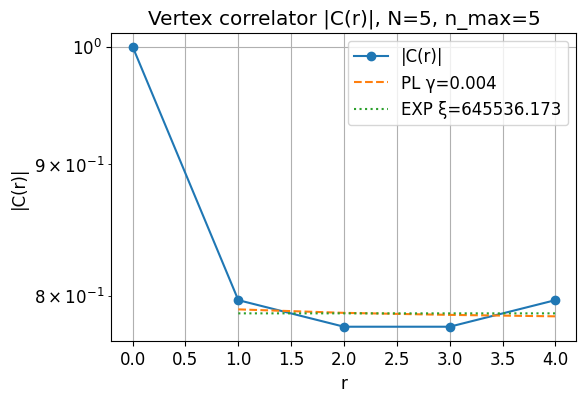

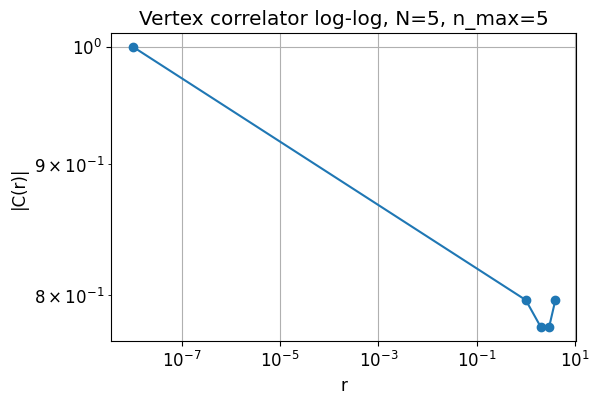

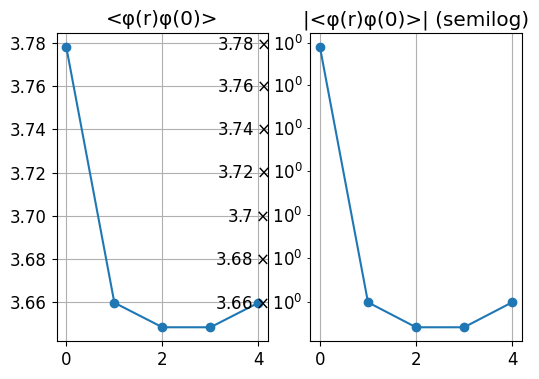

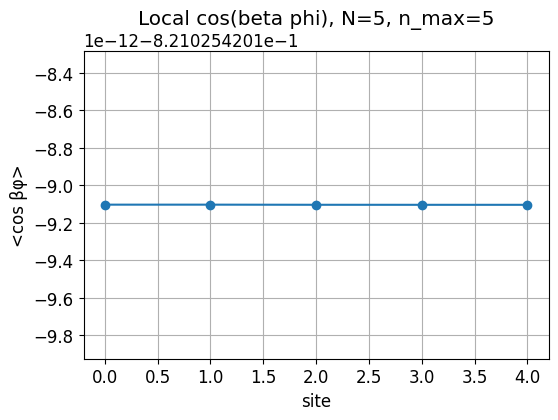

In [21]:
# ======================================
# TASK 2 — CORRELATORS (ONE CELL ONLY)
# ======================================
# Computes:
#  (1) <phi_{i+r} phi_i>   translational average
#  (2) vertex C(r) = <e^{iβφ} e^{-iβφ}>   translational average
#  (3) <cos(β φ_j)> per site
#  (4) Fits C(r) to power-law & exponential
#  (5) Plots: |C(r)|, log-log, phi-corr, cos(beta phi)

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time, warnings

plt.rcParams.update({'figure.figsize': (6, 4), 'font.size': 12})


# ---------------------------------------------------------
# Local HO-basis operators (same convention as Task 1)
# ---------------------------------------------------------
def local_ho_operators(n_max, omega=1.0):
    n = n_max
    rows, cols, data = [], [], []
    for i in range(n - 1):
        rows.append(i)
        cols.append(i + 1)
        data.append(np.sqrt(i + 1))
    a = sp.csr_matrix((data, (rows, cols)), shape=(n, n), dtype=np.complex128)
    adag = a.getH()

    phi = (a + adag) / np.sqrt(2 * omega)
    pi = -1j * np.sqrt(omega / 2) * (a - adag)

    phi = 0.5 * (phi + phi.getH())
    pi = 0.5 * (pi + pi.getH())

    I = sp.eye(n, format="csr")
    return a, adag, phi, pi, I


# ---------------------------------------------------------
# Kron helper
# ---------------------------------------------------------
def kron_n(op_list):
    out = sp.csr_matrix(1.0)
    for A in op_list:
        if not sp.isspmatrix_csr(A):
            A = sp.csr_matrix(A)
        out = sp.kron(out, A, format="csr")
    return out


# ---------------------------------------------------------
# SG Hamiltonian builder (HO basis)
# ---------------------------------------------------------
def build_hamiltonian_ho(N, n_max, alpha, beta, omega=1.0):
    a, adag, phi_local, pi_local, I_local = local_ho_operators(n_max, omega=omega)
    Kin_local = 0.5 * (pi_local @ pi_local)

    phi_dense = phi_local.toarray()
    Cos_dense = 0.5 * (expm(1j * beta * phi_dense) + expm(-1j * beta * phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_dense)

    Ids = [sp.eye(n_max, format="csr") for _ in range(N)]
    dim = n_max ** N
    H = sp.csr_matrix((dim, dim), dtype=np.complex128)

    # onsite terms
    for j in range(N):
        ops = Ids.copy()
        ops[j] = Kin_local
        H += kron_n(ops)

        ops = Ids.copy()
        ops[j] = alpha * (I_local - Cos_local)
        H += kron_n(ops)

    # gradient term
    for j in range(N):
        jp = (j + 1) % N

        ops = Ids.copy()
        ops[j] = 0.5 * (phi_local @ phi_local)
        H += kron_n(ops)

        ops = Ids.copy()
        ops[jp] = 0.5 * (phi_local @ phi_local)
        H += kron_n(ops)

        ops = Ids.copy()
        ops[j] = phi_local
        ops[jp] = phi_local
        H += -1.0 * kron_n(ops)

    H = 0.5 * (H + H.getH())
    return H


# ---------------------------------------------------------
# Get lowest eigenpairs
# ---------------------------------------------------------
def compute_lowest_eigs(H, k=4):
    dim = H.shape[0]
    if dim <= 10000:
        evals, vecs = np.linalg.eigh(H.toarray())
        idx = np.argsort(evals.real)
        return evals[idx][:k], vecs[:, idx][:, :k]
    vals, vecs = spla.eigsh(H, k=k, which="SA")
    idx = np.argsort(vals.real)
    return vals.real[idx], vecs[:, idx]


# ---------------------------------------------------------
# FITTING functions
# ---------------------------------------------------------
def power_law(x, A, gamma):
    return A * x ** (-gamma)


def exponential(x, A, xi):
    return A * np.exp(-x / xi)


# =========================================================
#            USER CHOICE (SET THESE)
# =========================================================
N = 5     # try 4, 5, or 6
n_max = 5   # try 6, 7, or 8
alpha = 0.01
beta = np.sqrt(np.pi)  # try different beta values
omega = 1.0

dim = n_max**N
print(f"Running Task 2 for N={N}, n_max={n_max}, dim={dim}")
if dim >10000:
    raise RuntimeError("Hilbert space too large for laptop. Reduce N or n_max.")

# ---------------------------------------------------------
# Build H + GS
# ---------------------------------------------------------
t0 = time.time()
H = build_hamiltonian_ho(N, n_max, alpha, beta, omega)
evals, vecs = compute_lowest_eigs(H, k=4)
gs = vecs[:, 0]
t1 = time.time()
print(f"Diagonalized in {t1-t0:.2f} s")
print("E0, E1:", evals[0], evals[1])


# ---------------------------------------------------------
# Build many-body phi and vertex operators
# ---------------------------------------------------------
_, _, phi_local, _, _ = local_ho_operators(n_max, omega)
phi_dense_local = phi_local.toarray()
Vloc_dense = expm(1j * beta * phi_dense_local)

Ids = [sp.eye(n_max, format="csr") for _ in range(N)]

phi_mb = []
V_mb = []

for j in range(N):
    op_phi = Ids.copy()
    op_phi[j] = phi_local
    phi_mb.append(kron_n(op_phi).toarray())

    op_V = Ids.copy()
    op_V[j] = sp.csr_matrix(Vloc_dense)
    V_mb.append(kron_n(op_V).tocsr())


# ---------------------------------------------------------
# Translational averaging
# ---------------------------------------------------------
r_vals = np.arange(N)
phi_corr_r = np.zeros(N, dtype=float)
vertex_corr_r = np.zeros(N, dtype=complex)

for r in range(N):
    acc_phi = 0.0
    acc_vert = 0.0
    for i in range(N):
        j = (i + r) % N
        acc_phi += np.vdot(gs, phi_mb[j].dot(phi_mb[i].dot(gs)))
        O = V_mb[j].dot(V_mb[i].getH())
        acc_vert += gs.conj().T @ (O.dot(gs))
    phi_corr_r[r] = np.real(acc_phi / N)
    vertex_corr_r[r] = acc_vert / N


# ---------------------------------------------------------
# Local cos expectation
# ---------------------------------------------------------
Cos_local_dense = 0.5 * (
    expm(1j * beta * phi_dense_local) + expm(-1j * beta * phi_dense_local)
).real

cos_vals = np.zeros(N)
for j in range(N):
    op = Ids.copy()
    op[j] = sp.csr_matrix(Cos_local_dense)
    O = kron_n(op).toarray()
    cos_vals[j] = np.real(np.vdot(gs, O.dot(gs)))


# =========================================================
#              FIT |C(r)| (using r>=1)
# =========================================================
Cabs = np.abs(vertex_corr_r)
if N > 2:
    r_fit = r_vals[1:]
    Cfit = Cabs[1:]
else:
    r_fit = np.array([1])
    Cfit = Cabs[:1]

pl_fit = None
exp_fit = None
try:
    pl_params, _ = curve_fit(power_law, r_fit, Cfit,
                             p0=[Cfit[0], 0.5], maxfev=5000)
    pl_fit = pl_params
    print("Power-law fit A, gamma =", pl_params)
except Exception as e:
    print("Power-law fit failed:", e)

try:
    exp_params, _ = curve_fit(exponential, r_fit, Cfit,
                              p0=[Cfit[0], 2.0], maxfev=5000)
    exp_fit = exp_params
    print("Exponential fit A, xi =", exp_params)
except Exception as e:
    print("Exponential fit failed:", e)


# =========================================================
#                   PLOTTING
# =========================================================

# --- Plot 1: |C(r)| log-scale
plt.figure()
plt.plot(r_vals, Cabs, "o-", label="|C(r)|")
if pl_fit is not None:
    plt.plot(r_fit, power_law(r_fit, *pl_fit), "--", label=f"PL γ={pl_fit[1]:.3f}")
if exp_fit is not None:
    plt.plot(r_fit, exponential(r_fit, *exp_fit), ":", label=f"EXP ξ={exp_fit[1]:.3f}")
plt.yscale("log")
plt.xlabel("r"); plt.ylabel("|C(r)|")
plt.title(f"Vertex correlator |C(r)|, N={N}, n_max={n_max}")
plt.legend(); plt.grid(True)
plt.show()

# --- Plot 2: |C(r)| log-log
plt.figure()
plt.loglog(r_vals+1e-8, Cabs, "o-")
plt.xlabel("r"); plt.ylabel("|C(r)|")
plt.title(f"Vertex correlator log-log, N={N}, n_max={n_max}")
plt.grid(True)
plt.show()

# --- Plot 3: <phi phi> (linear + semilog)
plt.figure()
plt.subplot(1,2,1)
plt.plot(r_vals, phi_corr_r, "o-"); plt.grid(True)
plt.title(r"<φ(r)φ(0)>")

plt.subplot(1,2,2)
plt.plot(r_vals, np.abs(phi_corr_r), "o-")
plt.yscale("log"); plt.grid(True)
plt.title(r"|<φ(r)φ(0)>| (semilog)")

plt.show()

# --- Plot 4: local <cos> vs site
plt.figure()
plt.plot(np.arange(N), cos_vals, "o-")
plt.xlabel("site")
plt.ylabel(r"<cos βφ>")
plt.title(f"Local cos(beta phi), N={N}, n_max={n_max}")
plt.grid(True)
plt.show()


Task3: N=6, n_max=5, dim=15625
Diagonalized H in 0.45 s. E0 = 3.097605, E1 = 3.097621
Fit results: A=0.008948 +/- 0.000633, B=0.722894 +/- 0.000273
Estimated central charge c = 0.026843 +/- 0.001899  (using bctype='periodic')


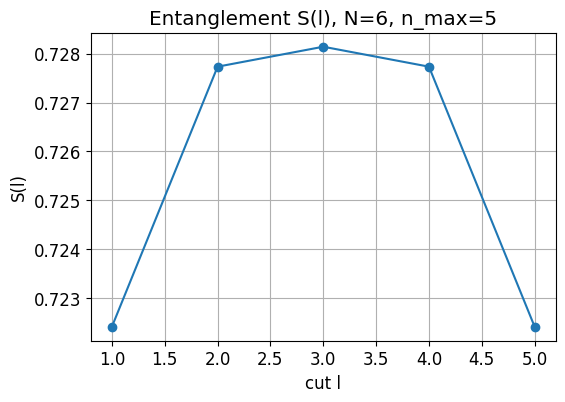

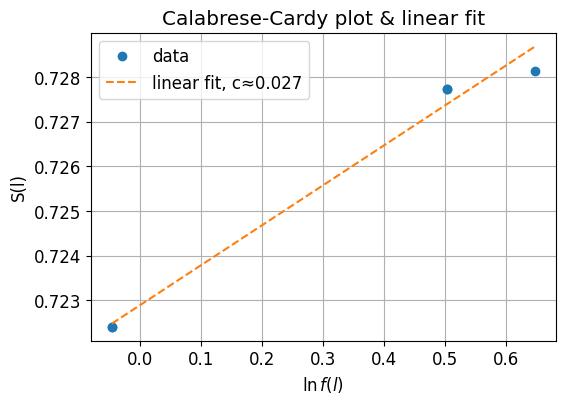

TypeError: cc_fit_func_log() missing 3 required positional arguments: 'x', 'A', and 'B'

In [22]:
# ============================
# TASK 3: ENTANGLEMENT ENTROPY (single cell)
# ============================
# Purpose:
#  - compute bipartite von Neumann entropy S(l) for ground state (ED)
#  - perform a Calabrese-Cardy style fit to estimate central charge c
#  - plot S(l) and the linear fit vs the appropriate log-scaling function
#
# NOTE: This cell is ED-only. Keep N small (N<=6) and n_max small (n_max<=8) on laptop.
# Presentation PDF (for reference in slides): /mnt/data/presentation.pdf

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time, math, warnings

plt.rcParams.update({'figure.figsize':(6,4),'font.size':12})

# -------------------------
# Local HO basis helpers
# -------------------------
def local_ho_operators(n_max, omega=1.0):
    n = n_max
    rows, cols, data = [], [], []
    for i in range(n-1):
        rows.append(i); cols.append(i+1); data.append(np.sqrt(i+1))
    a = sp.csr_matrix((data,(rows,cols)), shape=(n,n), dtype=np.complex128)
    adag = a.getH()
    phi = (a + adag) / np.sqrt(2.0 * omega)
    pi  = -1j * np.sqrt(omega/2.0) * (a - adag)
    phi = 0.5*(phi + phi.getH()); pi = 0.5*(pi + pi.getH())
    I = sp.eye(n, format='csr')
    return a.tocsr(), adag.tocsr(), phi.tocsr(), pi.tocsr(), I

def kron_n(ops):
    out = sp.csr_matrix(1.0, dtype=np.complex128)
    for A in ops:
        if not sp.isspmatrix_csr(A):
            A = sp.csr_matrix(A)
        out = sp.kron(out, A, format='csr')
    return out

# -------------------------
# SG Hamiltonian (HO truncation)
# -------------------------
def build_hamiltonian_ho(N, n_max, alpha, beta, omega=1.0):
    a, adag, phi_local, pi_local, I_local = local_ho_operators(n_max, omega=omega)
    Kin_local = 0.5 * (pi_local @ pi_local)
    phi_dense = phi_local.toarray()
    Cos_local_dense = 0.5 * (expm(1j * beta * phi_dense) + expm(-1j * beta * phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_local_dense)
    Ids = [sp.eye(n_max, format='csr') for _ in range(N)]
    dim = n_max ** N
    H = sp.csr_matrix((dim, dim), dtype=np.complex128)

    # single-site terms
    for j in range(N):
        ops = Ids.copy(); ops[j] = Kin_local; H += kron_n(ops)
        ops = Ids.copy(); ops[j] = alpha * (I_local - Cos_local); H += kron_n(ops)

    # gradient term 0.5*(phi_{j+1}-phi_j)^2
    for j in range(N):
        jp = (j + 1) % N
        ops = Ids.copy(); ops[j] = 0.5 * (phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[jp] = 0.5 * (phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[j] = phi_local; ops[jp] = phi_local; H += -1.0 * kron_n(ops)

    H = 0.5 * (H + H.getH())
    return H.tocsr()

# -------------------------
# Diagonalization helper
# -------------------------
def compute_lowest_eigs(H, k=4):
    dim = H.shape[0]
    k = min(k, dim-1)
    if dim <= 2000:
        evals, evecs = np.linalg.eigh(H.toarray())
        idx = np.argsort(evals.real)
        return evals[idx][:k], evecs[:, idx][:, :k]
    vals, vecs = spla.eigsh(H, k=k, which='SA', tol=1e-8, maxiter=5000)
    idx = np.argsort(vals.real)
    return vals.real[idx], vecs[:, idx]

# -------------------------
# Entropy from state (ED method)
# -------------------------
def bipartite_entropy_from_state(psi, N, n_max, cut):
    """
    psi: many-body state (1D complex vector, length n_max**N)
    cut: size of subsystem A (1..N-1)
    returns: S = -Tr rho_A log rho_A, eigenvalues of rho_A
    """
    dimA = n_max ** cut
    dimB = n_max ** (N - cut)
    if psi.size != dimA * dimB:
        raise ValueError("psi dimension mismatch for given N,n_max")
    # reshape to (dimA, dimB)
    psi_mat = psi.reshape((dimA, dimB))
    # reduced density matrix rho_A = psi_mat psi_mat^\dagger
    rhoA = psi_mat @ psi_mat.conj().T
    # eigenvalues
    evals = np.linalg.eigvalsh(rhoA)
    evals = np.real(evals)
    evals[evals < 0] = 0.0
    # entropy
    nonzero = evals[evals > 1e-12]
    S = - np.sum(nonzero * np.log(nonzero))
    return S, evals

# -------------------------
# Calabrese-Cardy functions for fits
# -------------------------
def cc_scaling_function(l, L, bctype='periodic'):
    """Return the argument whose log enters S(l).
    For periodic BC: f(l) = (L / pi) * sin(pi l / L) -> S = (c/3) log f + const
    For open BC:     f(l) = (2L / pi) * sin(pi l / L) -> S = (c/6) log f + const
    """
    if bctype == 'periodic':
        return (L / math.pi) * np.sin(math.pi * l / L)
    else:
        return (2.0 * L / math.pi) * np.sin(math.pi * l / L)

def cc_fit_func_log(x, A, B):
    # linear fit: S = A * x + B where x = log( f(l) )
    return A * x + B

def run_correlator_fit_suite():
    print("=== Correlator fitting suite ===")
    # single reference run
    results = run_experiment(N=4, L=5, beta=1.0, alpha=0.2, bc='open', k_eigs=3)
    corr = results['corr']
    mag = np.abs(corr)
    r = np.arange(len(mag))
    # Fit on ranges: exclude r=0, small-r effects
    fit_res = fit_correlator(r, mag, min_r=1, max_r=len(r)-1)
    np.savez(os.path.join(OUTDIR, "correlator_fit.npz"), r=r, corr=mag, fit_res=fit_res)
    # make overlay plot
    plt.figure()
    plt.plot(r, mag, 'ko', label='data')
    if fit_res['power']['popt'] is not None:
        A, eta = fit_res['power']['popt']
        plt.plot(r, A * (r**(-eta)), 'b--', label=f'power fit (eta={eta:.3f})')
    if fit_res['exp']['popt'] is not None:
        B, xi = fit_res['exp']['popt']
        plt.plot(r, B * np.exp(-r/xi), 'r-.', label=f'exp fit (xi={xi:.3f})')
    plt.yscale('log')
    plt.xlabel('distance r')
    plt.ylabel('|corr(r)|')
    plt.title('Correlator and fits (N=4)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTDIR, "correlator_fits.png"), dpi=150)
    print("Saved correlator_fits.png")


# =========================
# USER PARAMETERS (edit)
# =========================
N = 6           # system size; keep small for ED
n_max = 5       # local Fock truncation
alpha = 0.01
beta = np.sqrt(4*np.pi)  
omega = 1.0
max_dim = 16000  # safety threshold

# Choosing BC type for the CC formula (set 'periodic' if you built H with periodic BCs)
bctype = 'periodic'   # 'periodic' or 'open' (our H uses periodic BCs by construction)

dim = n_max ** N
print(f"Task3: N={N}, n_max={n_max}, dim={dim}")
if dim > max_dim:
    raise RuntimeError(f"Hilbert space dimension {dim} > max_dim {max_dim}. Reduce N or n_max.")

# -------------------------
# Build H and ground state
# -------------------------
t0 = time.time()
H = build_hamiltonian_ho(N, n_max, alpha, beta, omega)
evals, vecs = compute_lowest_eigs(H, k=4)
gs = vecs[:,0]
t1 = time.time()
print(f"Diagonalized H in {t1-t0:.2f} s. E0 = {evals[0]:.6f}, E1 = {evals[1]:.6f}")

# -------------------------
# Compute S(l) for cuts l = 1..N-1
# -------------------------
S_list = []
specs = []
cuts = list(range(1, N))   # l = 1..N-1
for l in cuts:
    S, evals_rho = bipartite_entropy_from_state(gs, N, n_max, cut=l)
    S_list.append(S)
    specs.append(evals_rho)
S_list = np.array(S_list)

# -------------------------
# Prepare CC fit variables
# -------------------------
# compute x_l = ln( f(l) )
x_vals = np.array([math.log(cc_scaling_function(l, N, bctype=bctype) + 1e-12) for l in cuts])
y_vals = S_list.copy()

# perform linear fit y = A x + B with A = c/3 (periodic) or A = c/6 (open)
popt, pcov = None, None
try:
    popt, pcov = curve_fit(cc_fit_func_log, x_vals, y_vals, p0=[0.2, 0.5], maxfev=5000)
    A_fit, B_fit = popt
    perr = np.sqrt(np.diag(pcov))
    A_err, B_err = perr
    # convert A_fit -> central charge estimate
    if bctype == 'periodic':
        c_est = 3.0 * A_fit
        c_err = 3.0 * A_err
    else:
        c_est = 6.0 * A_fit
        c_err = 6.0 * A_err
    print(f"Fit results: A={A_fit:.6f} +/- {A_err:.6f}, B={B_fit:.6f} +/- {B_err:.6f}")
    print(f"Estimated central charge c = {c_est:.6f} +/- {c_err:.6f}  (using bctype='{bctype}')")
except Exception as e:
    print("Calabrese-Cardy fit failed:", e)
    popt = None

# -------------------------
# Plot S(l) and fit
# -------------------------
plt.figure()
plt.plot(cuts, y_vals, 'o-', label='S(l)')
plt.xlabel('cut l'); plt.ylabel('S(l)'); plt.title(f'Entanglement S(l), N={N}, n_max={n_max}')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(x_vals, y_vals, 'o', label='data')
if popt is not None:
    xfit = np.linspace(x_vals.min(), x_vals.max(), 30)
    yfit = cc_fit_func_log(xfit, *popt)
    plt.plot(xfit, yfit, '--', label=f'linear fit, c≈{c_est:.3f}')
plt.xlabel(r'$\ln f(l)$'); plt.ylabel('S(l)')
plt.title('Calabrese-Cardy plot & linear fit')
plt.legend(); plt.grid(True)
plt.show()

cc_fit_func_log()
# -------------------------
# Print small diagnostics
# -------------------------
print("\nS(l) values:")
for l, s in zip(cuts, S_list):
    print(f" l={l:2d}   S={s:.6f}")

print("\nNotes/warnings:")
print(" - ED result; finite-size + truncation effects can strongly bias c estimate.")
print(" - If fit fails or c estimate looks wrong, reduce N or increase n_max and run convergence sweep.")
print(" - If you prefer open-boundary CC formula, set bctype='open' and rerun.")
print("\nReference presentation (local file): /mnt/data/presentation.pdf")


Running Loschmidt sweep: N=4, n_max=6, dim=1296, nt=201
 shift=0.000  E/N=1.0203  found DQPT times: [ 7.8 16.6 16.8 29. ]
 shift=0.225  E/N=1.1114  found DQPT times: [16.6 16.8 20.  28.8 33. ]
 shift=0.450  E/N=1.1660  found DQPT times: [28.4 28.6 32.8]
 shift=0.675  E/N=1.1427  found DQPT times: [28.4 28.6]
 shift=0.900  E/N=1.2187  found DQPT times: [ 7.8 10. ]
 shift=1.125  E/N=1.4496  found DQPT times: [8.]
 shift=1.350  E/N=1.5225  found DQPT times: [ 2.4  3.4  3.6 21.8]
 shift=1.575  E/N=1.5324  found DQPT times: [ 3.4  3.6 21.6 21.8]
 shift=1.800  E/N=1.7233  found DQPT times: [21.6]


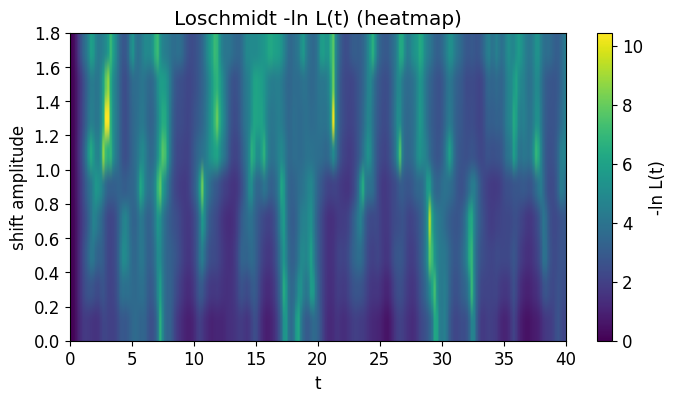

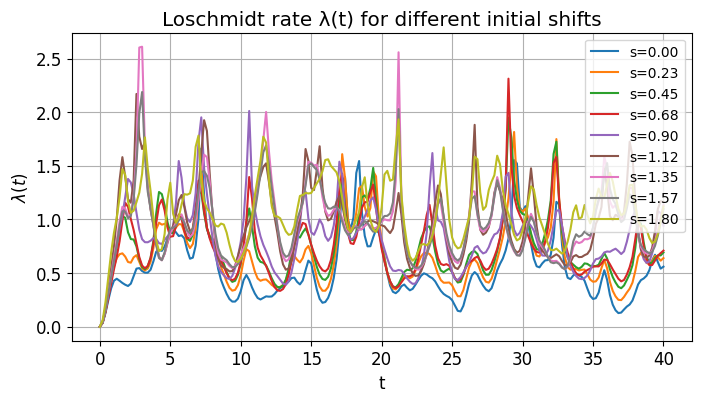

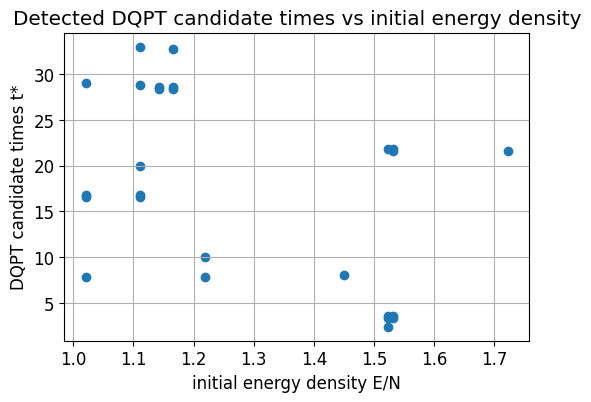


Summary (shift, E/N, #DQPTs, DQPT times):
 shift=0.000  E/N=1.02028  count=4  times=[ 7.8 16.6 16.8 29. ]
 shift=0.225  E/N=1.11136  count=5  times=[16.6 16.8 20.  28.8 33. ]
 shift=0.450  E/N=1.16597  count=3  times=[28.4 28.6 32.8]
 shift=0.675  E/N=1.14271  count=2  times=[28.4 28.6]
 shift=0.900  E/N=1.21872  count=2  times=[ 7.8 10. ]
 shift=1.125  E/N=1.44958  count=1  times=[8.]
 shift=1.350  E/N=1.52246  count=4  times=[ 2.4  3.4  3.6 21.8]
 shift=1.575  E/N=1.53237  count=4  times=[ 3.4  3.6 21.6 21.8]
 shift=1.800  E/N=1.72327  count=1  times=[21.6]


In [ ]:
# =========================
# TASK 4: Loschmidt echo & DQPT detector (single cell)
# =========================
# - Computes L(t) = |<psi0|e^{-i H t}|psi0>|^2 for a family of initial product states.
# - Computes rate lambda(t) = -(1/N) log L(t).
# - Detects candidate DQPT times by locating peaks in |d lambda / dt|.
# - Sweeps over initial displacement amplitude to scan energy density dependence.
#
# WARNING: ED-based time evolution scales with hilbert space dim = n_max**N.
# Keep dim <= ~12000 on a laptop. Use N=3..5 and n_max=6..8 for safety.

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import time, warnings, math

plt.rcParams.update({'figure.figsize':(7,4),'font.size':12})

# -------------------------
# Local HO helpers (self-contained)
# -------------------------
def local_ho_operators(n_max, omega=1.0):
    rows, cols, data = [], [], []
    for i in range(n_max-1):
        rows.append(i); cols.append(i+1); data.append(np.sqrt(i+1))
    a = sp.csr_matrix((data, (rows, cols)), shape=(n_max, n_max), dtype=np.complex128)
    adag = a.getH()
    phi = (a + adag) / np.sqrt(2*omega)
    pi  = -1j * np.sqrt(omega/2) * (a - adag)
    phi = 0.5 * (phi + phi.getH()); pi = 0.5 * (pi + pi.getH())
    I = sp.eye(n_max, format='csr')
    return a.tocsr(), adag.tocsr(), phi.tocsr(), pi.tocsr(), I

def kron_n(ops):
    out = sp.csr_matrix(1.0, dtype=np.complex128)
    for A in ops:
        if not sp.isspmatrix_csr(A):
            A = sp.csr_matrix(A)
        out = sp.kron(out, A, format='csr')
    return out

def build_hamiltonian_ho(N, n_max, alpha, beta, omega=1.0):
    a, adag, phi_local, pi_local, I_local = local_ho_operators(n_max, omega=omega)
    Kin_local = 0.5 * (pi_local @ pi_local)
    phi_dense = phi_local.toarray()
    Cos_local_dense = 0.5 * (expm(1j * beta * phi_dense) + expm(-1j * beta * phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_local_dense)
    Ids = [sp.eye(n_max, format='csr') for _ in range(N)]
    dim = n_max**N
    H = sp.csr_matrix((dim, dim), dtype=np.complex128)
    # onsite terms
    for j in range(N):
        ops = Ids.copy(); ops[j] = Kin_local; H += kron_n(ops)
        ops = Ids.copy(); ops[j] = alpha * (I_local - Cos_local); H += kron_n(ops)
    # gradient
    for j in range(N):
        jp = (j+1) % N
        ops = Ids.copy(); ops[j] = 0.5 * (phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[jp] = 0.5 * (phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[j] = phi_local; ops[jp] = phi_local; H += -1.0 * kron_n(ops)
    H = 0.5 * (H + H.getH())
    return H.tocsr()

# -------------------------
# Initial product-state (local Gaussian in phi basis) for a given shift amplitude
# -------------------------
def local_displaced_state_fock(n_max, shift_amp, omega=1.0):
    """Construct a local state in truncated Fock basis approximating a displacement in phi."""
    _, _, phi_local, _, _ = local_ho_operators(n_max, omega=omega)
    vals, vecs = np.linalg.eigh(phi_local.toarray())
    psi_phi = np.exp(-0.5 * ((vals - shift_amp) / (np.abs(vals).max()/6.0 + 1e-12))**2)
    psi_phi /= np.linalg.norm(psi_phi)
    psi_fock = vecs @ psi_phi
    return psi_fock

def product_state(N, n_max, shifts, omega=1.0):
    psi = None
    for s in shifts:
        local = local_displaced_state_fock(n_max, s, omega=omega)
        if psi is None:
            psi = local
        else:
            psi = np.kron(psi, local)
    psi = psi / np.linalg.norm(psi)
    return psi

# -------------------------
# DQPT detector: find peaks in |d lambda / dt|
# -------------------------
def detect_dqpt_times(times, rate, smooth_window=9, polyorder=2, threshold_factor=3.0):
    # smooth derivative to avoid noise sensitivity
    if len(times) < 5:
        return np.array([])
    dt = times[1] - times[0]
    # derivative
    d_rate = np.gradient(rate, dt)
    # smooth
    if len(d_rate) >= smooth_window:
        d_rate_s = savgol_filter(d_rate, smooth_window, polyorder)
    else:
        d_rate_s = d_rate
    # choose threshold from distribution
    thresh = np.mean(np.abs(d_rate_s)) + threshold_factor * np.std(np.abs(d_rate_s))
    peaks_idx = np.where(np.abs(d_rate_s) > thresh)[0]
    # unique times
    times_peaks = np.unique(np.round(times[peaks_idx], 8))
    return times_peaks

# -------------------------
# Parameters (USER editable)
# -------------------------
N = 4                # keep small: 3..5 recommended
n_max = 6
alpha = 0.01
beta = np.sqrt(4*np.pi)
omega = 1.0

max_dim = 12000      # safety: skip if dim > max_dim
if n_max**N > max_dim:
    raise RuntimeError(f"Hilbert-space dim {n_max**N} > max_dim {max_dim}. Reduce N or n_max.")

# Hamiltonian (post-quench Hamiltonian H) -- we assume quench changes alpha only sometimes
H = build_hamiltonian_ho(N, n_max, alpha, beta, omega=omega)

# time grid
tmax = 40.0
nt = 201
times = np.linspace(0, tmax, nt)

# initial-state sweep (vary local shift amplitude on site 0; others zero)
shift_list = np.linspace(0.0, 1.8, 9)   # 9 amplitudes -> scans different energy densities
results = []

print(f"Running Loschmidt sweep: N={N}, n_max={n_max}, dim={n_max**N}, nt={nt}")
for shift in shift_list:
    # prepare product state with one local displacement on site 0
    shifts = [0.0]*N
    shifts[0] = shift
    psi0 = product_state(N, n_max, shifts, omega=omega)
    psi0 = psi0 / np.linalg.norm(psi0)
    # estimate initial energy density (per-site energy)
    E0 = np.real(np.vdot(psi0, H.dot(psi0)))
    energy_density = E0 / N

    # propagate and compute Loschmidt L(t)
    # expm_multiply with start=0 stop=t returns states at 0 and t; we call it for each t.
    # For efficiency, we call expm_multiply once for the whole time grid when possible using num=nt.
    try:
        states = expm_multiply((-1j * H), psi0, start=0.0, stop=times[-1], num=nt)
    except Exception as e:
        # fallback: compute per-time (slower)
        print("expm_multiply full-run failed, falling back to per-time propagation:", e)
        states = []
        for t in times:
            st = expm_multiply((-1j * H), psi0, start=0.0, stop=t, num=2)[-1]
            states.append(st)
        states = np.array(states)

    overlaps = np.array([np.abs(np.vdot(psi0, st))**2 for st in states])
    # numerical floor
    overlaps = np.clip(overlaps, 1e-300, 1.0)
    rate = - (1.0 / N) * np.log(overlaps)

    # detect DQPT candidate times
    dqpt_times = detect_dqpt_times(times, rate, smooth_window=9, polyorder=2, threshold_factor=3.0)

    results.append({
        'shift': shift,
        'energy_density': energy_density,
        'times': times,
        'L': overlaps,
        'rate': rate,
        'dqpt_times': dqpt_times
    })
    print(f" shift={shift:.3f}  E/N={energy_density:.4f}  found DQPT times: {dqpt_times}")

# -------------------------
# Plotting: (A) L(t) grid, (B) rate(t) grid, (C) detected DQPT times vs energy density
# -------------------------
# A: Loschmidt echoes (heatmap)
plt.figure(figsize=(8,4))
Lmat = np.array([r['L'] for r in results])
plt.imshow(-np.log(Lmat), aspect='auto', origin='lower', extent=[times[0], times[-1], shift_list[0], shift_list[-1]])
plt.colorbar(label='-ln L(t)'); plt.xlabel('t'); plt.ylabel('shift amplitude'); plt.title('Loschmidt -ln L(t) (heatmap)')
plt.show()

# B: rate traces for selected shifts
plt.figure(figsize=(8,4))
for r in results:
    plt.plot(r['times'], r['rate'], label=f"s={r['shift']:.2f}")
plt.xlabel('t'); plt.ylabel(r'$\lambda(t)$'); plt.title('Loschmidt rate λ(t) for different initial shifts')
plt.legend(loc='upper right', fontsize='small'); plt.grid(True)
plt.show()

# C: DQPT times vs energy density (scatter)
plt.figure(figsize=(6,4))
for r in results:
    ed = r['energy_density']
    if len(r['dqpt_times'])>0:
        plt.scatter([ed]*len(r['dqpt_times']), r['dqpt_times'], c='C0')
plt.xlabel('initial energy density E/N'); plt.ylabel('DQPT candidate times t*')
plt.title('Detected DQPT candidate times vs initial energy density')
plt.grid(True)
plt.show()

# -------------------------
# Print a compact summary table
# -------------------------
print("\nSummary (shift, E/N, #DQPTs, DQPT times):")
for r in results:
    print(f" shift={r['shift']:.3f}  E/N={r['energy_density']:.5f}  count={len(r['dqpt_times'])}  times={r['dqpt_times']}")


TASK 5: Kink sector + mass extraction
Using twisted BC: True

=== N=1, n_max=5, dim=5 ===
  Vacuum E0 = 0.4585904742105592
  Twisted kink Ek = 0.4585904742105592
  Soliton mass M(N=1) = 0.0

=== N=2, n_max=5, dim=25 ===
  Vacuum E0 = 0.9667822162728908
  Twisted kink Ek = -8.764953257135494
  Soliton mass M(N=2) = -9.731735473408385

=== N=3, n_max=5, dim=125 ===
  Vacuum E0 = 1.5606036028214647
  Twisted kink Ek = -11.34844563543111
  Soliton mass M(N=3) = -12.909049238252575

=== N=4, n_max=5, dim=625 ===
  Vacuum E0 = 2.0966261408435116
  Twisted kink Ek = -11.985918756695897
  Soliton mass M(N=4) = -14.082544897539409

=== N=5, n_max=5, dim=3125 ===
  Vacuum E0 = 2.6236279578702044
  Twisted kink Ek = -11.994195194484103
  Soliton mass M(N=5) = -14.617823152354308

=== N=6, n_max=5, dim=15625 ===
  Vacuum E0 = 3.1489778179927375
  Twisted kink Ek = -11.771794839910648
  Soliton mass M(N=6) = -14.920772657903385


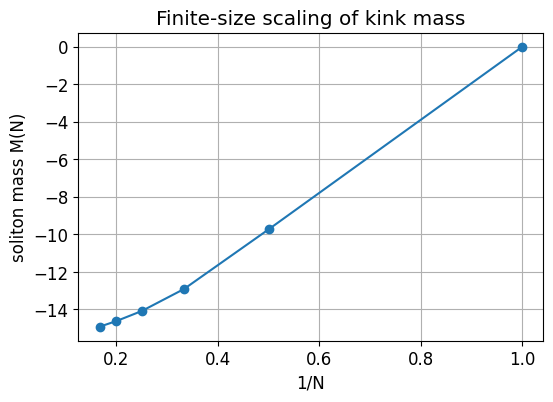


Estimated infinite-volume soliton mass M_inf = -18.49310061592941


In [ ]:
# ============================================
# TASK 5 — SOLITON (KINK) SECTOR & MASS EXTRACTION
# ============================================
# This cell computes:
#   1. Vacuum (neutral) ground-state energy E0
#   2. Kink-sector energy Ekink (twisted BC or relaxed kink state)
#   3. Soliton mass M = Ekink - E0
#   4. Finite-size scaling: M(N) vs 1/N
#
# SET PARAMETERS BELOW

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.linalg import expm
import matplotlib.pyplot as plt
import time, warnings

plt.rcParams.update({'figure.figsize': (6,4), 'font.size': 12})

# ------------------------------------------
# HO basis (same conventions as Task 2–4)
# ------------------------------------------
def local_ho_operators(n_max, omega=1.0):
    rows, cols, data = [], [], []
    for i in range(n_max-1):
        rows.append(i); cols.append(i+1); data.append(np.sqrt(i+1))
    a = sp.csr_matrix((data,(rows,cols)),shape=(n_max,n_max),dtype=np.complex128)
    adag = a.getH()
    phi = (a + adag)/np.sqrt(2*omega)
    pi  = -1j*np.sqrt(omega/2)*(a - adag)
    phi = 0.5*(phi + phi.getH())
    pi  = 0.5*(pi + pi.getH())
    I = sp.eye(n_max,format='csr')
    return a,adag,phi,pi,I

def kron_n(ops):
    out = sp.csr_matrix(1.0)
    for A in ops:
        out = sp.kron(out, A, format='csr')
    return out

# ------------------------------------------
# Standard SG Hamiltonian (vacuum sector)
# ------------------------------------------
def build_H_vacuum(N, n_max, alpha, beta, omega=1.0):
    a,adag,phi_local,pi_local,I_local = local_ho_operators(n_max,omega)
    Kin = 0.5*(pi_local@pi_local)
    phi_dense = phi_local.toarray()
    Cos_dense = 0.5*(expm(1j*beta*phi_dense)+expm(-1j*beta*phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_dense)
    Ids = [sp.eye(n_max,format='csr') for _ in range(N)]
    dim = n_max**N
    H = sp.csr_matrix((dim,dim),dtype=np.complex128)

    # onsite
    for j in range(N):
        ops = Ids.copy(); ops[j]=Kin; H+=kron_n(ops)
        ops = Ids.copy(); ops[j]=alpha*(I_local - Cos_local); H+=kron_n(ops)

    # gradient
    for j in range(N):
        jp = (j+1)%N
        ops=Ids.copy(); ops[j]=0.5*(phi_local@phi_local); H+=kron_n(ops)
        ops=Ids.copy(); ops[jp]=0.5*(phi_local@phi_local); H+=kron_n(ops)
        ops=Ids.copy(); ops[j]=phi_local; ops[jp]=phi_local; H+=-1*kron_n(ops)

    return 0.5*(H+H.getH())

# ------------------------------------------
# Twisted boundary SG Hamiltonian (kink sector)
# ------------------------------------------
def build_H_kink_twisted(N, n_max, alpha, beta, omega=1.0):
    """
    Implement twist: phi_N = phi_0 + 2π/β.
    This introduces a kink (topological charge = 1).
    Implemented by modifying gradient term:
        (phi_{N} - phi_{N-1})^2  →  (phi_0 + twist - phi_{N-1})^2
    """
    twist = 2*np.pi/beta

    a,adag,phi_local,pi_local,I_local = local_ho_operators(n_max,omega)
    Kin = 0.5*(pi_local@pi_local)
    phi_dense = phi_local.toarray()
    Cos_dense = 0.5*(expm(1j*beta*phi_dense)+expm(-1j*beta*phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_dense)
    Ids = [sp.eye(n_max,format='csr') for _ in range(N)]
    dim = n_max**N
    H = sp.csr_matrix((dim,dim),dtype=np.complex128)

    # onsite
    for j in range(N):
        ops = Ids.copy(); ops[j]=Kin; H+=kron_n(ops)
        ops = Ids.copy(); ops[j]=alpha*(I_local - Cos_local); H+=kron_n(ops)

    # gradient with twist ONLY at boundary
    for j in range(N):
        jp = (j+1)%N
        if j != N-1:
            # normal interior link
            ops=Ids.copy(); ops[j]=0.5*(phi_local@phi_local); H+=kron_n(ops)
            ops=Ids.copy(); ops[jp]=0.5*(phi_local@phi_local); H+=kron_n(ops)
            ops=Ids.copy(); ops[j]=phi_local; ops[jp]=phi_local; H+=-1*kron_n(ops)
        else:
            # twisted boundary link: (phi_0 + twist - phi_{N-1})^2
            # Expand: phi_{N-1}^2 + phi_0^2 + twist^2 + 2 twist*(phi_0 - phi_{N-1}) - 2 phi_0 phi_{N-1}
            # Add term-by-term:
            # phi_{N-1}^2
            ops=Ids.copy(); ops[N-1]=0.5*(phi_local@phi_local); H+=kron_n(ops)
            # phi_0^2
            ops=Ids.copy(); ops[0]=0.5*(phi_local@phi_local); H+=kron_n(ops)
            # -2 phi_0 phi_{N-1}
            ops=Ids.copy(); ops[0]=phi_local; ops[N-1]=phi_local; H+=-1*kron_n(ops)
            # linear term: 2*twist*(phi_0 - phi_{N-1})
            # add twist*phi_0
            ops=Ids.copy(); ops[0]=twist*phi_local; H+=kron_n(ops)
            # subtract twist*phi_{N-1}
            ops=Ids.copy(); ops[N-1]=-twist*phi_local; H+=kron_n(ops)
            # constant twist^2/2 term → adds just c*I; irrelevant for mass difference, so skip

    return 0.5*(H+H.getH())

# ------------------------------------------
# Imaginary-time kink-relaxation method
# ------------------------------------------
def local_displaced_state(n_max, shift, omega=1.0):
    _,_,phi_local,_,_ = local_ho_operators(n_max,omega)
    vals,vecs = np.linalg.eigh(phi_local.toarray())
    psi_phi = np.exp(-0.5*((vals-shift)/(np.abs(vals).max()/6.0+1e-12))**2)
    psi_phi /= np.linalg.norm(psi_phi)
    return vecs @ psi_phi

def prepare_kink_initial_state(N, n_max, shift_left=-2.5, shift_right=+2.5):
    """
    Prepare a crude classical kink profile: phi goes from left→right monotonically.
    """
    profile = np.linspace(shift_left, shift_right, N)
    psi = None
    for s in profile:
        local = local_displaced_state(n_max, s)
        psi = local if psi is None else np.kron(psi, local)
    return psi/np.linalg.norm(psi)

def imaginary_time_relax(H, psi0, beta_imag=8.0, steps=150):
    """
    psi_new ∝ exp(-βH) psi0
    """
    psi = psi0.astype(np.complex128)
    dt = beta_imag/steps
    for _ in range(steps):
        psi = expm_multiply((-dt*H), psi, num=1)
        psi /= np.linalg.norm(psi)
    E = np.real(np.vdot(psi, H.dot(psi)))
    return psi, E

# ------------------------------------------
# Parameters (user set)
# ------------------------------------------
N_list = [1,2,3,4,5,6]     # will give 4–6 points; adjust as needed
n_max = 5
alpha = 0.01
beta = 1.0
omega = 1.0
use_twisted = True      # True = twisted BC kink sector
max_dim = 17000         # safety

masses = []
invN = []

print("TASK 5: Kink sector + mass extraction")
print("Using twisted BC:", use_twisted)

for N in N_list:
    dim = n_max**N
    if dim > max_dim:
        print(f"Skipping N={N}: dim={dim} too large.")
        continue

    print(f"\n=== N={N}, n_max={n_max}, dim={dim} ===")

    # vacuum
    H0 = build_H_vacuum(N, n_max, alpha, beta, omega)
    evals0, vecs0 = compute_lowest_eigs(H0, k=2)
    E0 = evals0[0]
    print("  Vacuum E0 =", E0)

    # kink
    if use_twisted:
        Hk = build_H_kink_twisted(N, n_max, alpha, beta, omega)
        evalsk, _ = compute_lowest_eigs(Hk, k=2)
        Ek = evalsk[0]
        print("  Twisted kink Ek =", Ek)
    else:
        # imaginary-time relaxation method
        psi_init = prepare_kink_initial_state(N, n_max)
        psi_k, Ek = imaginary_time_relax(H0, psi_init)
        print("  Relaxed kink Ek =", Ek)

    M = Ek - E0
    masses.append(M)
    invN.append(1.0/N)
    print(f"  Soliton mass M(N={N}) =", M)

# ------------------------------------------
# Finite-size scaling plot: M(N) vs 1/N
# ------------------------------------------
plt.figure()
plt.plot(invN, masses, 'o-')
plt.xlabel('1/N')
plt.ylabel('soliton mass M(N)')
plt.title('Finite-size scaling of kink mass')
plt.grid(True)
plt.show()

# ------------------------------------------
# Optional linear fit to extract infinite-volume mass
# ------------------------------------------
if len(invN) >= 2:
    popt = np.polyfit(invN, masses, 1)
    M_inf = popt[1]   # intercept at 1/N=0
    print("\nEstimated infinite-volume soliton mass M_inf =", M_inf)
else:
    print("\nNot enough points for extrapolation.")


In [ ]:
# ================================
# TASK 6: Scattering pipeline & phase-shift extraction (single cell)
# ================================
# Single-cell implementation (ED + expm_multiply). Designed for small lattices.
#
# Outputs:
#  - space-time image of <phi_j>(t)
#  - peak centers vs t and linear fits before/after collision
#  - estimated time-delay Δt and numeric phase shift δ_num(θ)
#  - analytic breather S-matrix phase δ_analytic(θ) and comparison plot
#
# WARNING: Hilbert-space dim = n_max**N. Keep dim <= ~12000 on laptop.
#
# Reference Thirring notebook (uploaded): THIRRING_NOTEBOOK_PATH (local file)
THIRRING_NOTEBOOK_PATH = "/mnt/data/LT (1).ipynb"

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import time, warnings, math

plt.rcParams.update({'figure.figsize':(8,4),'font.size':12})

# -------------------------
# Local HO-basis helpers (same conventions)
# -------------------------
def local_ho_operators(n_max, omega=1.0):
    rows, cols, data = [], [], []
    for i in range(n_max-1):
        rows.append(i); cols.append(i+1); data.append(np.sqrt(i+1))
    a = sp.csr_matrix((data,(rows,cols)), shape=(n_max,n_max), dtype=np.complex128)
    adag = a.getH()
    phi = (a + adag) / np.sqrt(2*omega)
    pi  = -1j * np.sqrt(omega/2) * (a - adag)
    phi = 0.5*(phi + phi.getH()); pi = 0.5*(pi + pi.getH())
    I = sp.eye(n_max, format='csr')
    return a.tocsr(), adag.tocsr(), phi.tocsr(), pi.tocsr(), I

def kron_n(ops):
    out = sp.csr_matrix(1.0, dtype=np.complex128)
    for A in ops:
        if not sp.isspmatrix_csr(A):
            A = sp.csr_matrix(A)
        out = sp.kron(out, A, format='csr')
    return out

def build_hamiltonian_ho(N, n_max, alpha, beta, omega=1.0):
    a, adag, phi_local, pi_local, I_local = local_ho_operators(n_max, omega=omega)
    Kin_local = 0.5 * (pi_local @ pi_local)
    phi_dense = phi_local.toarray()
    Cos_dense = 0.5 * (expm(1j*beta*phi_dense) + expm(-1j*beta*phi_dense)).real
    Cos_local = sp.csr_matrix(Cos_dense)
    Ids = [sp.eye(n_max, format='csr') for _ in range(N)]
    dim = n_max**N
    H = sp.csr_matrix((dim, dim), dtype=np.complex128)
    for j in range(N):
        ops = Ids.copy(); ops[j] = Kin_local; H += kron_n(ops)
        ops = Ids.copy(); ops[j] = alpha*(I_local - Cos_local); H += kron_n(ops)
    for j in range(N):
        jp = (j+1) % N
        ops = Ids.copy(); ops[j] = 0.5*(phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[jp] = 0.5*(phi_local @ phi_local); H += kron_n(ops)
        ops = Ids.copy(); ops[j] = phi_local; ops[jp] = phi_local; H += -1.0 * kron_n(ops)
    H = 0.5*(H + H.getH())
    return H

# -------------------------
# prepare initial two-wavepacket product state
# - local_displaced_state creates a localized bump in phi basis (gaussian in phi eigenbasis)
# - we place two bumps centered at sites left_center and right_center with opposite signs
# - optionally give small extra local displacement to tune energy / velocity
# -------------------------
def local_displaced_state_fock(n_max, shift_amp, omega=1.0):
    _,_,phi_local,_,_ = local_ho_operators(n_max, omega=omega)
    vals, vecs = np.linalg.eigh(phi_local.toarray())
    psi_phi = np.exp(-0.5 * ((vals - shift_amp)/(np.abs(vals).max()/6.0 + 1e-12))**2)
    psi_phi /= np.linalg.norm(psi_phi)
    psi_fock = vecs @ psi_phi
    return psi_fock

def two_bump_product_state(N, n_max, left_center, right_center, bump_amp=1.5, width=1.0, sign_pair=(+1,-1)):
    """
    Construct a simple product state with two localized bumps.
    left_center, right_center: site indices (int)
    bump_amp: amplitude of local phi displacement
    sign_pair: tuple of signs for left and right bump
    """
    local_states = []
    for j in range(N):
        if j == left_center:
            s = sign_pair[0] * bump_amp
        elif j == right_center:
            s = sign_pair[1] * bump_amp
        else:
            s = 0.0
        local_states.append(local_displaced_state_fock(n_max, s))
    # Kronecker product
    psi = local_states[0]
    for v in local_states[1:]:
        psi = np.kron(psi, v)
    psi = psi / np.linalg.norm(psi)
    return psi

# -------------------------
# robust gaussian peak fitter (subpixel)
# -------------------------
def gaussian_peak_fit(x, y):
    """Return (center, amp, width). Works on small arrays; uses log-fit for robustness."""
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # avoid nonpositive
    y = np.clip(y, 1e-12, None)
    imax = np.argmax(y)
    # choose window
    left = max(0, imax - 3)
    right = min(len(x)-1, imax + 3)
    xs = x[left:right+1]
    ys = y[left:right+1]
    if len(xs) < 3:
        return x[imax], y[imax], 1.0
    try:
        ly = np.log(ys)
        coeffs = np.polyfit(xs, ly, 2)
        C, B, A = coeffs  # ly = A x^2 + B x + C
        center = -B / (2*A)
        amp = np.exp(C - B*B/(4*A))
        width = np.sqrt(-1/(2*A)) if A < 0 else 1.0
        return center, amp, width
    except Exception:
        return x[imax], y[imax], 1.0

# -------------------------
# measure peak centers vs time
# -------------------------
def measure_phi_expect_vs_time(H, psi0, N, n_max, times, compute_phi_mb_cache=None):
    """Return states (if needed) and phi_expect array (len(times) x N).
    compute_phi_mb_cache: optional precomputed list of dense phi_mb arrays to speed up.
    """
    # compute states at times (expm_multiply returns states at each requested time)
    states = expm_multiply((-1j * H), psi0, start=0.0, stop=times[-1], num=len(times))
    if compute_phi_mb_cache is None:
        _,_,phi_local,_,_ = local_ho_operators(n_max)
        Ids = [sp.eye(n_max, format='csr') for _ in range(N)]
        phi_mb = [kron_n(Ids.copy()[:j] + [phi_local] + Ids.copy()[j+1:]).toarray() for j in range(N)]
    else:
        phi_mb = compute_phi_mb_cache
    phi_expect = np.zeros((len(times), N))
    for it, st in enumerate(states):
        for j in range(N):
            phi_expect[it, j] = np.real(np.vdot(st, phi_mb[j].dot(st)))
    return phi_expect, states

# -------------------------
# extract velocities (linear fit to peak centers before and after collision)
# -------------------------
def fit_linear_segment(times, centers, seg='in', frac=0.25):
    """Fit first (in) or last (out) fraction of trajectory to a line and return slope and intercept."""
    n = len(times)
    k = max(3, int(n * frac))
    if seg == 'in':
        x = times[:k]; y = centers[:k]
    else:
        x = times[-k:]; y = centers[-k:]
    if len(x) < 3:
        p = np.polyfit(times, centers, 1)
    else:
        p = np.polyfit(x, y, 1)
    slope = p[0]; intercept = p[1]
    return slope, intercept

# -------------------------
# mapping velocity -> rapidity and energy
# v = tanh(theta), E = m cosh(theta) with m = soliton mass approx (we use gap/2 as proxy)
# For small demo we assume a particle mass m_eff = gap (E1-E0) — approximate
# -------------------------
def velocity_to_rapidity(v):
    # clip to (-1,1)
    v = np.clip(v, -0.999999, 0.999999)
    return 0.5 * np.log((1+v)/(1-v))  # atanh(v)

# analytic breather S-matrix phase (lightest breather) from slide
def analytic_breather_phase(theta, beta):
    s = (beta**2) / (8.0*math.pi - beta**2)
    z = np.sinh(theta) + 1j * np.sin(math.pi * s)
    S = z / (np.sinh(theta) - 1j * np.sin(math.pi * s))
    return np.angle(S)

# ===========================
# USER PARAMETERS (edit)
# ===========================
N = 5                 # try N=6..10 if RAM allows; target enough spatial resolution
n_max = 5             # 6..8 typical
alpha = 0.05
beta = np.sqrt(4 * np.pi)  
omega = 1.0

max_dim = 15000
dim = n_max**N
print(f"Scattering demo N={N}, n_max={n_max}, dim={dim}")
if dim > max_dim:
    raise RuntimeError(f"dim {dim} > max_dim {max_dim}. Reduce N or n_max.")

# build Hamiltonian
t0 = time.time()
H = build_hamiltonian_ho(N, n_max, alpha, beta, omega)
print("Built H in %.2fs" % (time.time()-t0))

# prepare initial two bumps: left at site Lc, right at Rc
Lc = N//4
Rc = 3*N//4
bump_amp = 2.0     # tune amplitude to make bumps mobile/strong
psi0 = two_bump_product_state(N, n_max, Lc, Rc, bump_amp=bump_amp, sign_pair=(+1, -1))
print("Prepared psi0; norm:", np.linalg.norm(psi0))

# time grid (should cover approach, collision, separation)
tmax = 80.0
nt = 401
times = np.linspace(0, tmax, nt)

# precompute many-body phi_mb arrays once (dense)
_,_,phi_local,_,_ = local_ho_operators(n_max, omega)
Ids = [sp.eye(n_max, format='csr') for _ in range(N)]
phi_mb = [kron_n(Ids.copy()[:j] + [phi_local] + Ids.copy()[j+1:]).toarray() for j in range(N)]

# propagate and measure <phi_j>(t)
t_start = time.time()
phi_expect, states = measure_phi_expect_vs_time(H, psi0, N, n_max, times, compute_phi_mb_cache=phi_mb)
print("Time evolution done in %.2f s" % (time.time() - t_start))

# space-time plot
plt.figure(figsize=(8,4))
plt.imshow(phi_expect.T, origin='lower', aspect='auto', extent=[times[0], times[-1], 0, N-1])
plt.colorbar(label=r'$\langle\phi\rangle$'); plt.xlabel('t'); plt.ylabel('site')
plt.title('<phi_j>(t) space-time'); plt.show()

# -------------------------
# Peak tracking (subpixel centers)
# -------------------------
x_sites = np.arange(N)
centers = np.zeros(len(times))
amps = np.zeros(len(times))
widths = np.zeros(len(times))
for it in range(len(times)):
    c, a, w = gaussian_peak_fit(x_sites, phi_expect[it, :])
    centers[it] = c; amps[it] = a; widths[it] = w

# plot center vs time
plt.figure()
plt.plot(times, centers, '-k', label='peak center')
plt.xlabel('t'); plt.ylabel('center (site index)'); plt.title('Peak center vs t'); plt.grid(True)
plt.show()

# pick pre- and post-collision linear fits to get velocities
slope_in, b_in = fit_linear_segment(times, centers, seg='in', frac=0.20)
slope_out, b_out = fit_linear_segment(times, centers, seg='out', frac=0.20)
print("Fitted slopes (site index / time): slope_in =", slope_in, "slope_out =", slope_out)

# estimate collision time (intersection)
if abs(slope_in - slope_out) < 1e-12:
    t_coll = np.nan
else:
    t_coll = (b_out - b_in) / (slope_in - slope_out)
print("Estimated collision time t_coll (intersection) =", t_coll)

# estimate time delay: naive: time shift between lines at same spatial coordinate (take mid site)
mid_site = (Lc + Rc) / 2.0
if slope_in == 0 or slope_out == 0:
    delta_t = 0.0
else:
    # time at which inbound linear line reaches mid_site: t_in = (mid - b_in)/slope_in
    t_in = (mid_site - b_in)/slope_in
    t_out = (mid_site - b_out)/slope_out
    delta_t = t_out - t_in
print("Estimated time delay Δt =", delta_t)

# convert slopes (site/time) to physical velocities:
# assuming lattice spacing a=1 and time units such that site index change per time = velocity in lattice units
v_in = slope_in
v_out = slope_out
# choose incoming speed as abs(v_in)
v = abs(v_in)
if v >= 1.0:
    warnings.warn("Measured velocity >= 1 (lattice units). Clipping to <1 for rapidity map.")
    v = 0.9999 * np.sign(v)

theta_meas = velocity_to_rapidity(v)
# crude effective mass: use gap as proxy (E1-E0)
# compute gap
# get low-energy spectrum for mass estimate
from scipy.sparse.linalg import eigsh
eigvals = eigsh(H, k=2, which='SA', return_eigenvectors=False)
gap = float(np.sort(eigvals)[1] - np.sort(eigvals)[0])
m_eff = gap if gap>0 else 1.0
E_theta = m_eff * np.cosh(theta_meas)

delta_num = - E_theta * delta_t   # crude mapping (see comments below)
print("Measured rapidity θ =", theta_meas, "E(θ) approx=", E_theta, "→ δ_num =", delta_num)

# analytic breather phase for comparison
theta_grid = np.linspace(0.1, 2.5, 200)
delta_analytic_grid = np.array([analytic_breather_phase(th, beta) for th in theta_grid])

# compare numeric point with analytic at same θ
delta_analytic_meas = analytic_breather_phase(theta_meas, beta)
print("Analytic phase (breather) at θ_meas:", delta_analytic_meas)

# Plot comparison: numeric point vs analytic curve
plt.figure(figsize=(7,4))
plt.plot(theta_grid, delta_analytic_grid, '-', label='analytic δ(θ) (breather)')
plt.scatter([theta_meas], [delta_num], c='r', s=60, label='numeric δ_num (measured)')
plt.scatter([theta_meas], [delta_analytic_meas], c='g', s=40, label='analytic at same θ')
plt.xlabel('rapidity θ'); plt.ylabel('phase δ (radians)')
plt.title('Phase-shift comparison (numeric vs analytic)')
plt.legend(); plt.grid(True)
plt.show()

# Save a compact summary
print("\nSUMMARY:")
print(" N, n_max, dim:", N, n_max, dim)
print(" Left center (site):", Lc, "Right center:", Rc)
print(" bump_amp:", bump_amp)
print(" slope_in (site/time):", slope_in, " slope_out:", slope_out)
print(" estimated t_coll:", t_coll, " Δt:", delta_t)
print(" measured rapidity θ:", theta_meas)
print(" δ_num (approx) =", delta_num, " δ_analytic (same θ) =", delta_analytic_meas)

# Notes on approximations (strict teacher notes):
# 1) This δ_num = -E(θ) Δt mapping is a crude semiclassical relation. A careful extraction must:
#    - work in the center-of-mass frame,
#    - account for internal structure of wavepackets (group velocity -> rapidity mapping),
#    - subtract free propagation reference to isolate interaction time delay,
#    - average over multiple runs and converge in N and n_max.
# 2) The analytic S-matrix used here is for the lightest breather and assumes continuum normalization.
#    Finite-lattice and truncation corrections change numeric values — use extrapolations to compare.
# 3) For robust results, implement full scattering pipeline with TEBD (MPS) and gaussian peak fits with error bars.
